# 06 - Interpretating ML models

In [2]:
# data processing
import pandas as pd
import numpy as np
import scipy.stats as sp

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# interpretability
from utils import feature_importance_utils
import shap

from joblib import load

In [3]:
df_train = pd.read_csv('datasets/dataset_preprocessed_train.csv')
X = df_train.drop(columns = ['SARS-Cov-2 exam result'])
y = df_train[['SARS-Cov-2 exam result']]

In [4]:
df_train.columns
features = np.array(df_train.columns[:-1])

In [5]:
svm = load('saves/svm.bin')
random_forest = load('saves/random_forest.bin')
logistic_regression = load('saves/logistic_regression.bin')

In [152]:
def predictions(df,y_pred):
    true_positives = df[(df['SARS-Cov-2 exam result'] == 1) & (y_pred == 1)]
    false_positives = df[(df['SARS-Cov-2 exam result'] == 0) & (y_pred == 1)]
    true_negatives = df[(df['SARS-Cov-2 exam result'] == 0) & (y_pred == 0)]
    false_negatives = df[(df['SARS-Cov-2 exam result'] == 1) & (y_pred == 0)]
    return true_positives,false_positives,true_negatives,false_negatives

In [153]:
patients_negative = df_train[df_train['SARS-Cov-2 exam result'] == 0].drop(columns = ['SARS-Cov-2 exam result'])
patients_positive = df_train[df_train['SARS-Cov-2 exam result'] == 1].drop(columns = ['SARS-Cov-2 exam result'])

In [155]:
y_pred_rf = random_forest.predict(X)
true_positives_rf,false_positives_rf,true_negatives_rf,false_negatives_rf = predictions(df_train,y_pred_rf)

y_pred_lr = logistic_regression.predict(X)
true_positives_lr,false_positives_lr,true_negatives_lr,false_negatives_lr = predictions(df_train,y_pred_lr)

y_pred_svm = svm.predict(X)
true_positives_svm,false_positives_svm,true_negatives_svm,false_negatives_svm = predictions(df_train,y_pred_svm)

## Analysing weights of Logistic Regression

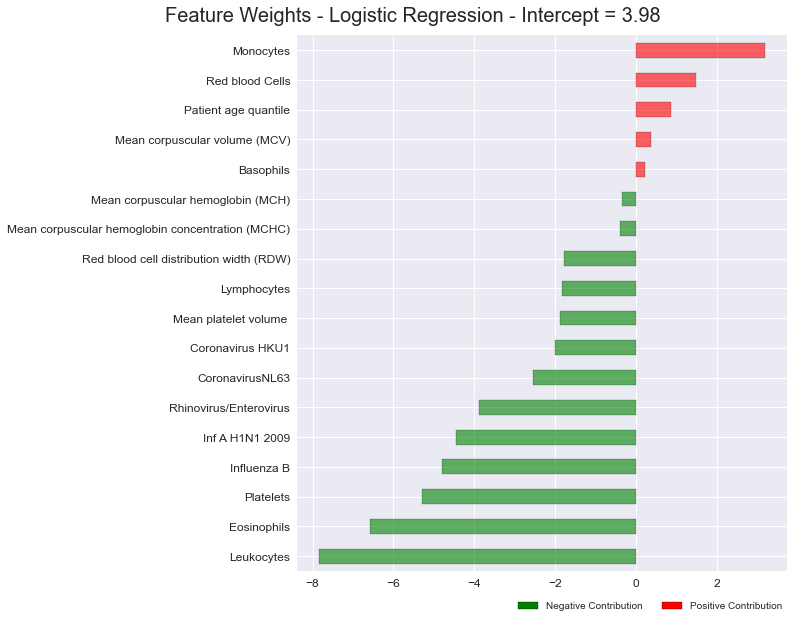

In [16]:
feature_importance_utils.show_feature_weights(features,logistic_regression.coef_.ravel(),'Logistic Regression - Intercept = %3.2f' % logistic_regression.intercept_[0], color = ('r','g'), absolute_values = False)

### Some patients with COVID-19

In [150]:
y_pred = logistic_regression.predict(X)
true_positives,false_positives,true_negatives,false_negatives = predictions(df_train,y_pred)

# Interpreting Random Forest and SVM with SHAP

In [87]:
# load JS visualization code to notebook
shap.initjs()

In [85]:
explainer_rf = shap.TreeExplainer(random_forest)
shap_values_rf = explainer_rf.shap_values(X)[0]

In [24]:
explainer_svm = shap.KernelExplainer(random_forest)
shap_values_svm = explainer_svm.shap_values(X)

Using 253 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [170]:
shap_value_single = explainer_svm.shap_values(X.iloc[0])[0]

## SHAP Summary Plots

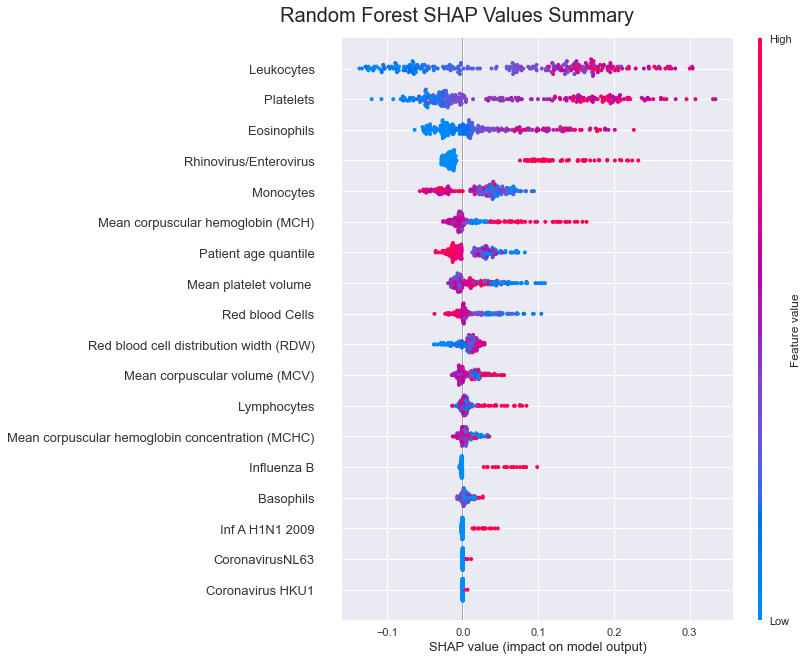

In [86]:
fig,ax = plt.subplots(1)
fig.suptitle('Random Forest SHAP Values Summary',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.93, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.summary_plot(shap_values_rf, X)

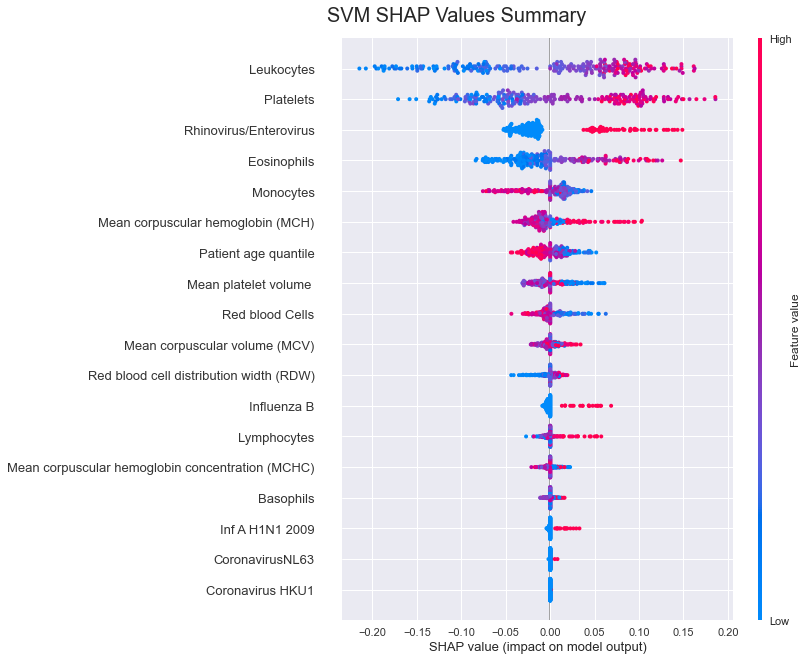

In [81]:

fig,ax = plt.subplots(1)
fig.suptitle('SVM SHAP Values Summary',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.93, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.summary_plot(shap_values_svm, X)

## Prediction Paths

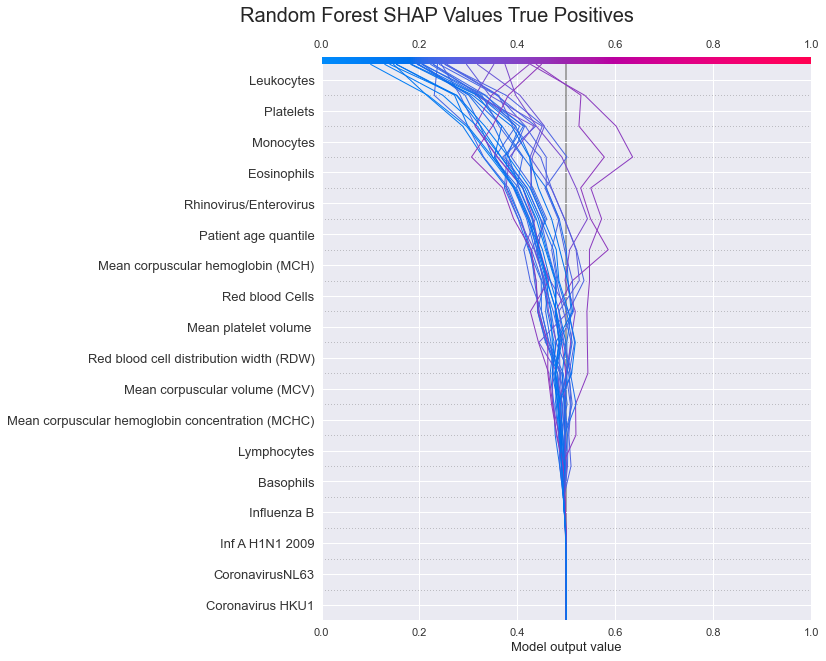

In [216]:
fig,ax = plt.subplots(1)
fig.suptitle('Random Forest SHAP Values True Positives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_rf.expected_value[1], shap_values_rf[tp_rf], X.iloc[tp_rf,:],xlim=(0,1))

In [239]:
tp_svm = true_positives_svm.index.ravel()
tp_rf = true_positives_rf.index.ravel()

fp_svm = false_positives_svm.index.ravel()
fp_rf = false_positives_rf.index.ravel()

tn_svm = true_negatives_svm.index.ravel()
tn_rf = true_negatives_rf.index.ravel()

fn_svm = false_negatives_svm.index.ravel()
fn_rf = false_negatives_rf.index.ravel()

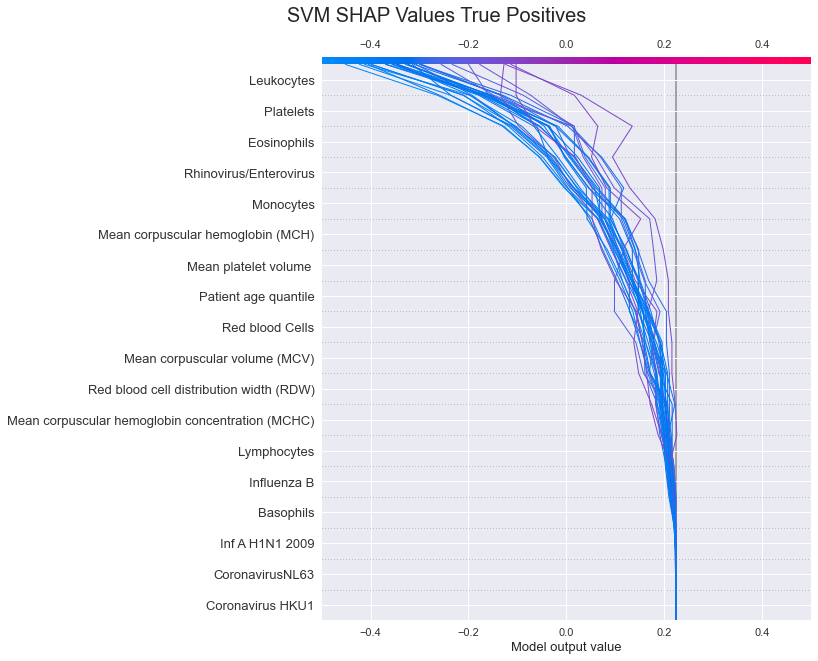

In [222]:
fig,ax = plt.subplots(1)
fig.suptitle('SVM SHAP Values True Positives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_svm.expected_value[1], shap_values_svm[tp_svm], X.iloc[tp_svm,:],xlim=(-0.5,0.5))

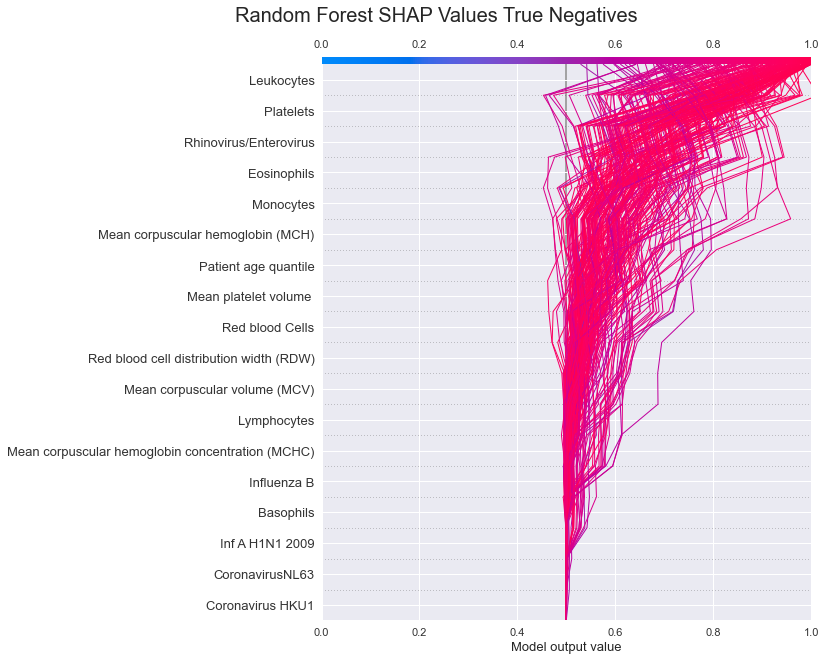

In [217]:
fig,ax = plt.subplots(1)
fig.suptitle('Random Forest SHAP Values True Negatives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_rf.expected_value[1], shap_values_rf[tn_rf], X.iloc[tn_rf,:],xlim=(0,1))

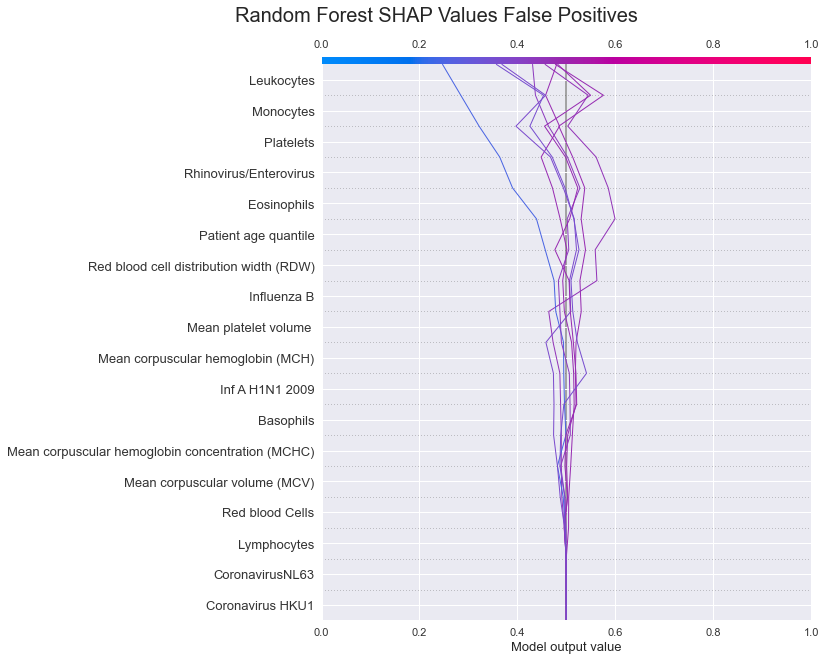

In [218]:
fig,ax = plt.subplots(1)
fig.suptitle('Random Forest SHAP Values False Positives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_rf.expected_value[1], shap_values_rf[fp_rf], X.iloc[fp_rf,:],xlim=(0,1))

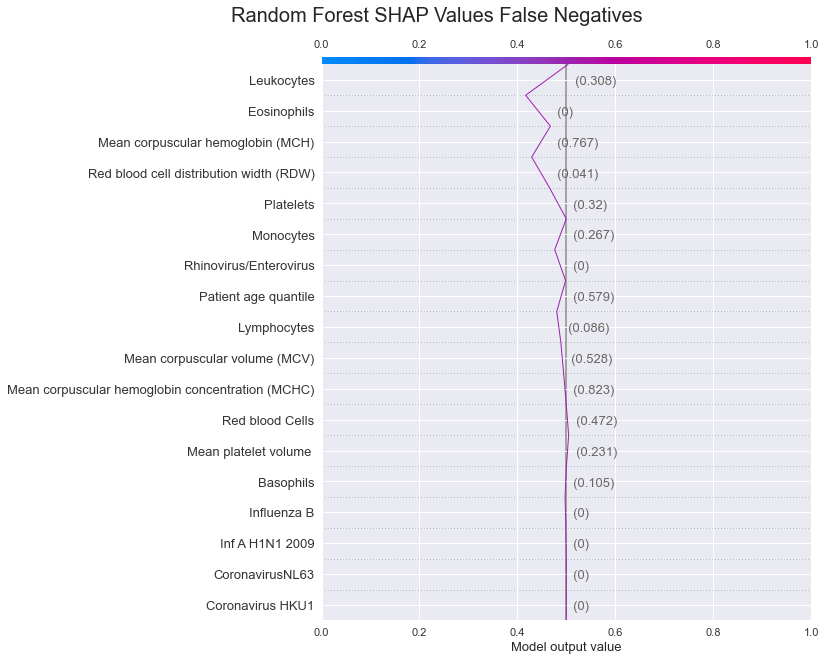

In [219]:
fig,ax = plt.subplots(1)
fig.suptitle('Random Forest SHAP Values False Negatives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_rf.expected_value[1], shap_values_rf[fn_rf], X.iloc[fn_rf,:],xlim=(0,1))

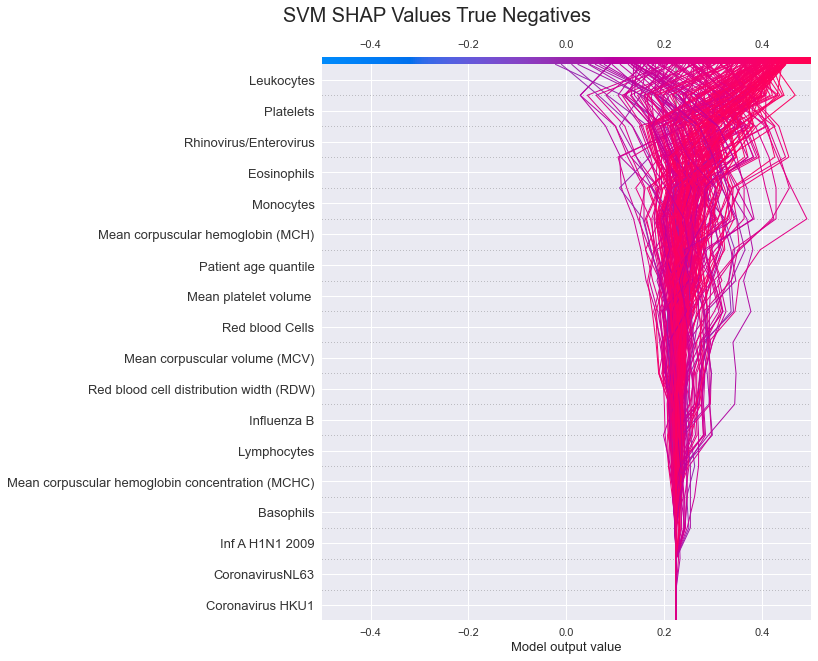

In [223]:
fig,ax = plt.subplots(1)
fig.suptitle('SVM SHAP Values True Negatives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_svm.expected_value[1], shap_values_svm[tn_svm], X.iloc[tn_svm,:],xlim=(-0.5,0.5))

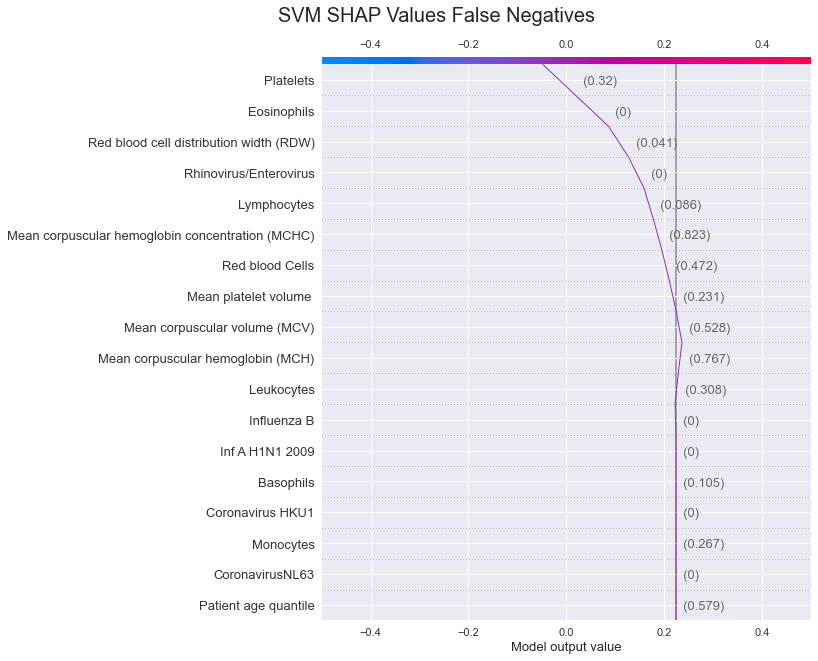

In [225]:
fig,ax = plt.subplots(1)
fig.suptitle('SVM SHAP Values False Negatives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_svm.expected_value[1], shap_values_svm[fn_svm], X.iloc[fn_svm,:],xlim=(-0.5,0.5))

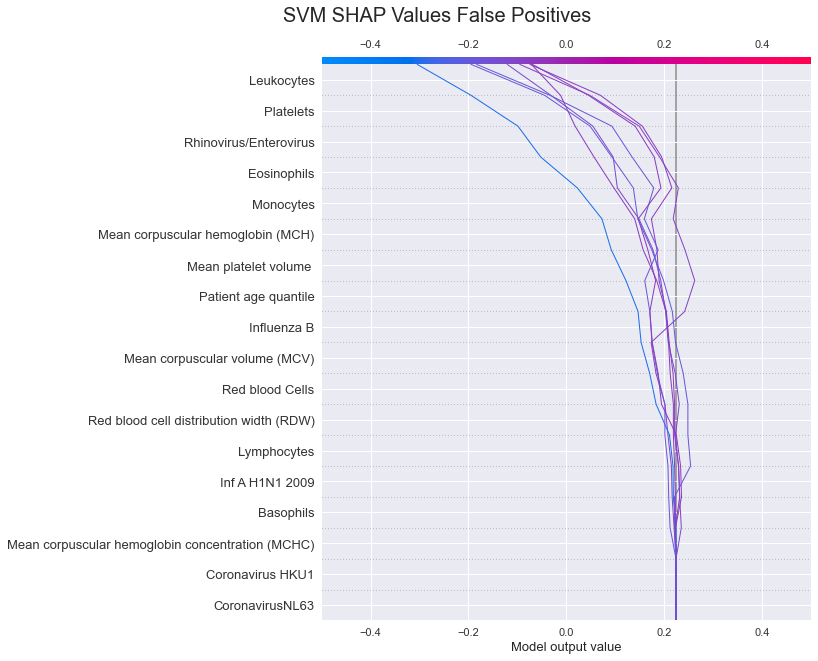

In [224]:
fig,ax = plt.subplots(1)
fig.suptitle('SVM SHAP Values False Positives',x = 0.3,fontsize = 20)
plt.subplots_adjust(top=0.90, bottom=0, left=0.10, right=0.95, hspace=0.40, wspace=0.35)

shap.decision_plot(explainer_svm.expected_value[1], shap_values_svm[fp_svm], X.iloc[fp_svm,:],xlim=(-0.5,0.5))

## Dependence Plots for Platelets, Leukocytes, Eosinophils and Monocytes

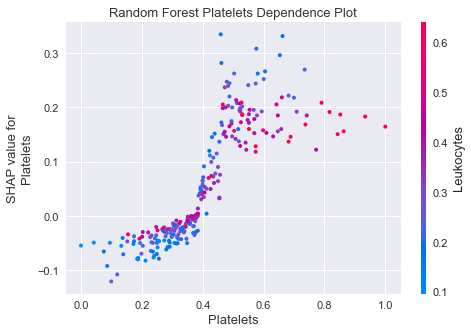

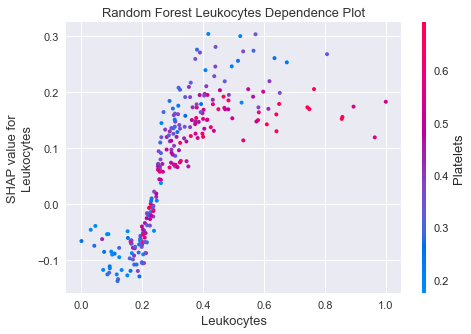

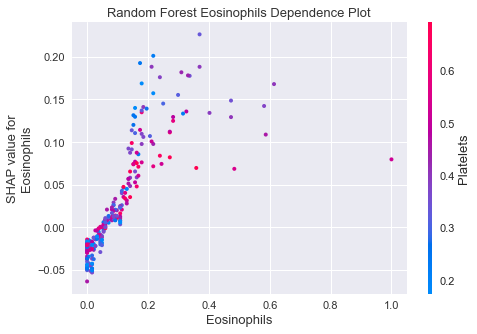

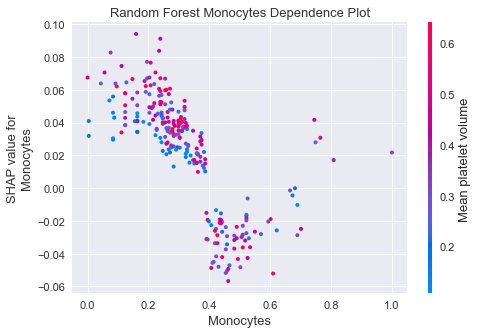

In [237]:
shap.dependence_plot("Platelets", shap_values_rf, X,title = 'Random Forest Platelets Dependence Plot')
shap.dependence_plot("Leukocytes", shap_values_rf, X,title = 'Random Forest Leukocytes Dependence Plot')
shap.dependence_plot("Eosinophils", shap_values_rf, X,title = 'Random Forest Eosinophils Dependence Plot')
shap.dependence_plot("Monocytes", shap_values_rf, X,title = 'Random Forest Monocytes Dependence Plot')

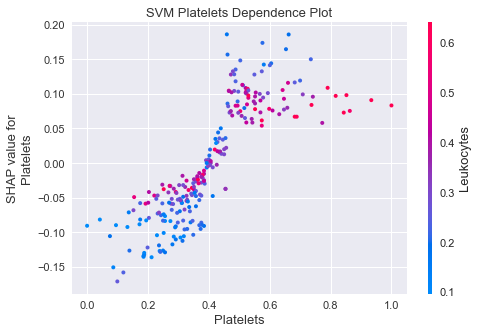

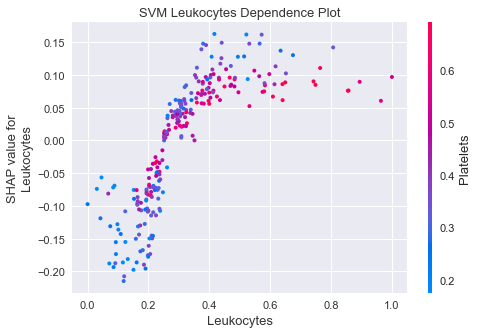

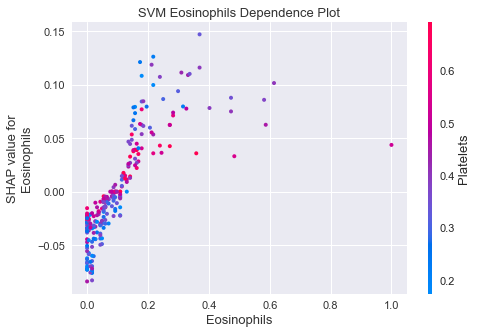

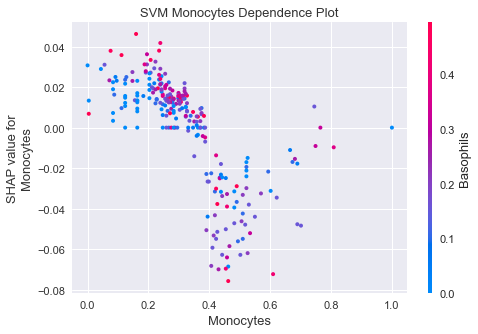

In [238]:
shap.dependence_plot("Platelets", shap_values_svm, X,title = 'SVM Platelets Dependence Plot')
shap.dependence_plot("Leukocytes", shap_values_svm, X,title = 'SVM Leukocytes Dependence Plot')
shap.dependence_plot("Eosinophils", shap_values_svm, X,title = 'SVM Eosinophils Dependence Plot')
shap.dependence_plot("Monocytes", shap_values_svm, X,title = 'SVM Monocytes Dependence Plot')

## Single Predictions - SVM

In [253]:
shap.force_plot(explainer_svm.expected_value[1], shap_values_svm[tp_svm][0], X.iloc[tp_svm[0],:])

In [254]:
shap.force_plot(explainer_svm.expected_value[1], shap_values_svm[tn_svm][0], X.iloc[tn_svm[0],:])

In [255]:
shap.force_plot(explainer_svm.expected_value[1], shap_values_svm[fp_svm][0], X.iloc[fp_svm[0],:])

In [256]:
shap.force_plot(explainer_svm.expected_value[1], shap_values_svm[fn_svm][0], X.iloc[fn_svm[0],:])

## Single Predictions - RF

In [257]:
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[tp_rf][0], X.iloc[tp_rf[0],:])

In [258]:
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[tn_rf][0], X.iloc[tn_rf[0],:])

In [259]:
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[fp_rf][0], X.iloc[fp_rf[0],:])

In [260]:
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[fn_rf][0], X.iloc[fn_rf[0],:])